# Исследование объявлений о продаже квартир

Мы имеем архив данных сервиса Яндекс.Недвижимость с объявлениями о продаже квартир в Санкт-Петербурге и соседних населённых пунктах за несколько лет. Нужно научиться определять рыночную стоимость объектов недвижимости. Наша задача — установить наиболее значимые параметры, что позволит построить автоматизированную систему, которая будет отслеживать аномалии и мошенническую деятельность.

По каждой квартире на продажу доступны два вида данных. Первые вписаны пользователем, вторые получены автоматически на основе картографических данных. Например, расстояние до центра, аэропорта, ближайшего парка и водоёма. 

In [1]:
import sys
from distutils.version import StrictVersion

if StrictVersion(sys.version.split()[0]) < StrictVersion('3.8.0'):
    !pip install -U seaborn

In [100]:
from datetime import datetime

import numpy as np
import pandas as pd
import seaborn as sns
from matplotlib import pyplot as plt
from sklearn.linear_model import LinearRegression

In [3]:
pd.set_option("display.precision", 2)
pd.set_option("display.max_columns", 50)

In [138]:
sns.set_style("whitegrid")

In [4]:
plt.rcParams["figure.figsize"] = (12, 8)

## Изучение данных из файла

### Описание данных

Пользовательские:
- `balcony` — число балконов
- `ceiling_height` — высота потолков (м)
- `first_day_exposition` — дата публикации
- `floor` — этаж
- `floors_total` — всего этажей в доме
- `is_apartment` — апартаменты (булев тип)
- `kitchen_area` — площадь кухни в квадратных метрах (м²)
- `last_price` — цена на момент снятия с публикации
- `living_area` — жилая площадь в квадратных метрах(м²)
- `locality_name` — название населённого пункта
- `open_plan` — свободная планировка (булев тип)
- `rooms` — число комнат
- `studio` — квартира-студия (булев тип)
- `total_area` — площадь квартиры в квадратных метрах (м²)
- `total_images` — число фотографий квартиры в объявлении

От Яндекса:
- `airports_nearest` — расстояние до ближайшего аэропорта в метрах (м)
- `cityCenters_nearest` — расстояние до центра города (м)
- `days_exposition` — сколько дней было размещено объявление (от публикации до снятия)
- `parks_around3000` — число парков в радиусе 3 км
- `parks_nearest` — расстояние до ближайшего парка (м)
- `ponds_around3000` — число водоёмов в радиусе 3 км
- `ponds_nearest` — расстояние до ближайшего водоёма (м)

In [5]:
try:
    df = pd.read_csv("real_estate_data.csv", sep="\t")
except FileNotFoundError:
    df = pd.read_csv("/datasets/real_estate_data.csv", sep="\t")

In [6]:
df.head()

In [7]:
df.describe()

In [8]:
df.info()

Бросается в глаза, что некоторые колонки имеют неправильный тип: `first_day_exposition` содержит дату в строковом формате, `is_apartment` по смыслу и наполнению является флагом, так что его из строкового надо превратить в логический тип. Кроме того, такие колонки, как `floors_total`, `balcony`, `parks_around3000`, `ponds_around3000` и `days_exposition` описывают счётнве категории, но колонки имеют вещественный тип.

Ещё одна потенциальная аномалия в данных: максимальная цена, составляющая 763 млн. рублей. Впрочем, недвижимость за \$10млн. хоть и редка, но точно не невозможна.

In [9]:
df[df.last_price == df.last_price.max()]

Похоже на пентхаус, тогда цена может быть и оправданной.

### Вывод

В целом ряде столбцов имеются пропуски, которые нужно по возможности заполнить перед началом анализа данных. Кроме того, типы данных некоторых столбцов не соответсвуют содержимому. Это также предстоит исправить

## Предобработка данных

Как мы уже установили ранее, в данных имеются многочисленные пропуски, рассмотрим их:

In [10]:
df.isna().mean() * 100

In [11]:
df.isna().sum()

Пропуски имеются в следующих столбцах:

- `ceiling_height` &mdash; пропусков почти 40%. В этом столбце имеются и странные выбросы: присутствуют как очень маленькие значения (1м), так и очень большие (100м), что вряд ли соответсвует действительности. 
- `floors_total` &mdash; есть небольшое количество пропусков (0,36%). Если не удастся найти неочевидные закономерности, заполнить будет не просто.
- `living_area` &mdash; важная характеристика квартиры, если её заполнить неправильно, можно сильно исказить результаты анализа. Здесь также наблюдаются выбросы: при медианном значении 30м², минимальное &mdash; 2, а максимальное &mdash; 409.
- `is_apartment` &mdash; здесь, видимо, следует NaN интерпретировать как False. Тем более, что квартир с этим признаком заявлено всего 50 из 23699.
- `kitchen_area` &mdash; ещё одна важная количественная характеристика квартиры с 10% пропусков. Здесь также наблюдаются значительный разброс: медиана &mdash; 9,1м², минимум &mdash; 1,3 (такие кухни вообще бывают?), а максимум &mdash; 112.
- `balcony` &mdash; также как и признак аппартаменов, отсутсвующее значение можно понимать как отсутсвие признака, т.е. False.
- `locality_name` &mdash; пропуски адекватно заполнить может быть затруднительно без доплнительной информации.
- `airports_nearest`, `cityCenters_nearest`, `parks_around3000`, `ponds_around3000` &mdash; пропусков по 23%. Судя по тому, что эти данные подставляются сервисом Яндекса, имеют место проблемы с геолокацией недвижимости.
- `parks_nearest` и `ponds_nearest` &mdash; пропусков ещё больше (66 и 62%, соответсвенно). Причина &mdash; таже, что и предыдущий пункт, хотя доля пропусков различается. Видимо, сервис определяет расстояние до ближайшего парка и пруда только если оно не превышает 3 км. Самый далёкий из парков &mdash; в 3190 м, а самый далёкий пруд &mdash; в 1344 м. 
- `days_exposition` - возможно, что причина 13% пропусков в том, что на момент выгрузки эта величина была определена не для всех объявлений, поскольку часть из них оставалась актуальной (не были сняты)

### Подготовка параметров "балкон", "аппартаменты" и "дата публикации"

Наиболее просто трактуются пропуски в таких параметрах, как `is_apartment` и `balcony`: пропуск соответсует отсутствию признака. За одно исправим и их типы: количество балконов, очевидно, должно быть целочисленным. А `is_apartment` &mdash; булев флаг

In [12]:
df["balcony"] = df["balcony"].fillna(0)
df["balcony"] = df["balcony"].astype("int")

In [13]:
df["is_apartment"] = df["is_apartment"].fillna(False)
df["is_apartment"] = df["is_apartment"].astype("bool")

Также можно привести к правильному типу столбце `first_day_exposition`. В нём нет пропусков и его сразу можно преобразовать в `datetime`:

In [14]:
df["first_day_exposition"] = pd.to_datetime(
    df["first_day_exposition"], format="%Y-%m-%dT%H:%M:%S", errors="coerce"
)

#### Вывод

Мы заполнили провуски в `is_apartment` и `balcony` и привели их к целому типу, а также сделали `first_day_exposition` датой.

### Время размещения публикации

Столбец `days_exposition` содержит пропуски, которые, как мы предположили, соответсвуют объявлениям, которые не были сняты в момент выгрузки данных, так что время экспозиции просто не было определно. В выгрузке нет ни одного события, которое бы произошло после 3 мая 2019 года, очевидно, это и есть дата выгрузки данных. При заполнении пропусков следует учитывать, что подставляемое значение должно быть не меньше, чем количество дней между опубликованием и 4 мая 2019, так что простая замена средним (181 день) или медианой (95 дней) не подойдёт

In [15]:
df["days_exposition"].describe()

Посмотрим статистику "незакрытых" объявлений:

In [16]:
(
    datetime(2019, 5, 4) - df[df["days_exposition"].isna()].first_day_exposition
).dt.days.describe()

Обе величины статистически близки, так что можно заменить экспозицию её нижней оценкой (в предположении, что неснятые объявления были сняты 4 мая 2019)

In [17]:
df["days_exposition"] = np.where(
    df["days_exposition"].isna(),
    (datetime(2019, 5, 4) - df["first_day_exposition"]).dt.days,
    df["days_exposition"],
)

In [18]:
df["days_exposition"].isna().sum()

Можно было бы привести `days_exposition` к `Timedelta`, семантически это совершенно верно, но с целыми оперировать удобнее 

In [19]:
df["days_exposition"] = df["days_exposition"].astype("int")

#### Вывод

Мы заполнили пропуски в параметре времени размещения объявлений, но менять тип столбца не стали: дв задачах анализа будет удобнее использовать кличество дннй как целое число, нежели как Timedelta  

### Населённый пункт

Ещё один более-менее очевидный параметр с пропусками &mdash; населённый пункт. Из общих соображений его заполнить затруднительно. Но есть оин момент: если значение расстояния до центра Санкт-Петербурга известно и не велико (не превышает 12км, как подсказывают нам Яндекс.Карты), можно сделать предположение, что мы имеем дело с квартирой в черте города.

In [20]:
df["locality_name"] = np.where(
    df["locality_name"].isna() & (df["cityCenters_nearest"] < 12_000),
    "Санкт-Петербург",
    df["locality_name"],
)

Остальные неизвестные наслённые пункты придётся заполнить значением "Unknown", поскольку ничего определённого о них мы сказать не можем. Можно и вовсе удалить, ибо объявление о продаже квартиры неизвестно где имеет невысокую ценность.

In [21]:
df["locality_name"].fillna("Unknown", inplace=True)

In [22]:
df[df["locality_name"] == "Unknown"].shape[0], df["locality_name"].isna().sum()

#### Вывод

По мере возможности, постарались разрешить неопределённость в населённом пункте: для квартир близких центру города был занан в качестве населённого пункта "Санкт-Петербург", для остальных &mdash; "Unknown". 

### Высота потолка

Важный параметр квартир с большим числом пропусков &mdash; высота потолков. Помимо пропусков, здесь имеются ещё и странные выбросы: трудно себе представить жилые помещения с высотой потолков в 1 или 100 метров, это явно ошибочные значения. Изучим их подробнее:

In [23]:
df[df["ceiling_height"] < 2.4]

Обычно, высота потолков в "хрущёвках" начинается от 2,4-2,45м. Можно допустить некоторое уменьшение высоты за счёт использования натяжных потолков и покрытий пола, допустим, до 2,3м. Но значения 2м и меньше кажутся очень странными (соответсвуют ли они вообще нормам для жилой недвижимости?). Так же было бы логично предположить связь между высотой потолков и удельной ценой квартиры: традиционно бюджетное жильё имеет невысокие потолки в пределах 2,7-2,8м, тогда как в бизне-классе потолки бывают и 3,5-4м. 

Это подтверждается и диаграммой рассеяния в пространстве "высота потолков"-"цена квадратного метра"  

In [24]:
df["m2_price"] = df["last_price"] / df["total_area"]

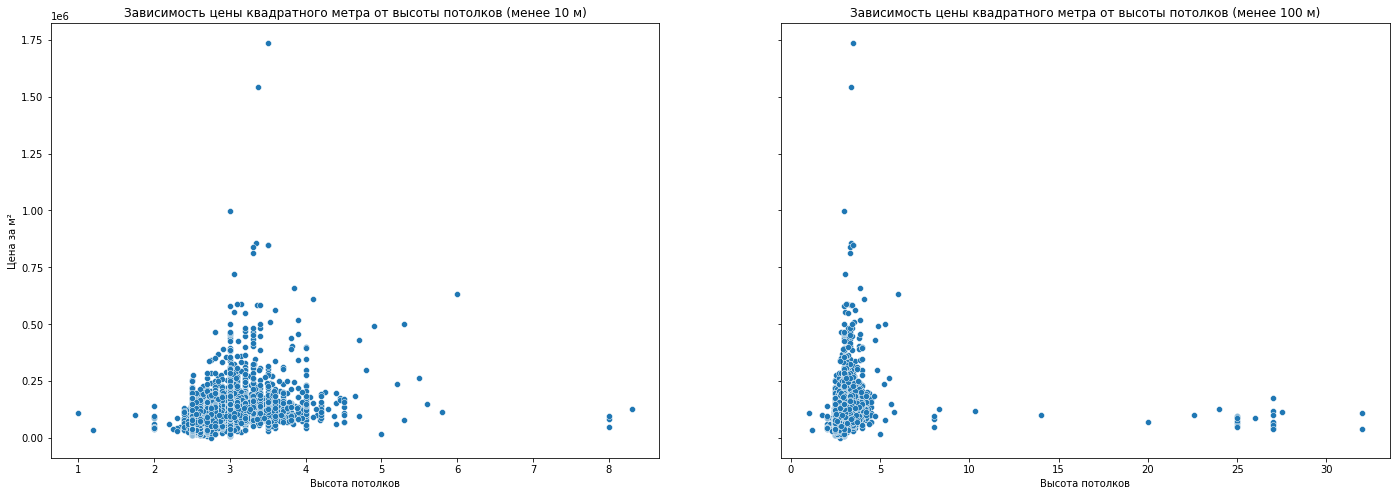

In [25]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

sns.scatterplot(
    ax=ax[0], data=df[df["ceiling_height"] < 10], x="ceiling_height", y="m2_price"
)
ax[0].set_title("Зависимость цены квадратного метра от высоты потолков (менее 10 м)")
ax[0].set_xlabel("Высота потолков")
ax[0].set_ylabel("Цена за м²")

sns.scatterplot(
    ax=ax[1], data=df[df["ceiling_height"] < 100], x="ceiling_height", y="m2_price"
)
ax[1].set_title("Зависимость цены квадратного метра от высоты потолков (менее 100 м)")
ax[1].set_xlabel("Высота потолков")
ax[1].set_ylabel("Цена за м²");

На диаграмме видно, что объявления с высотой потолка 2м и меньше, а также с высотой  больше 4,5м находятся в стороне от общей сравнительно плотной группы точек.

На основании этого, будем считать подобные значения выбросами и исключим из вычисления медианы. Сами же величины сохраним, возможно, они будут полезными признаками при анализе.

In [26]:
df.loc[
    (df["ceiling_height"] > 2) & (df["ceiling_height"] <= 4.5), "ceiling_height"
].describe()

Медианное значение высоты потолка вполне согласуется со здравым смыслом и стандартное отклонение не велико. Остаётся заполнить пропуски:

In [27]:
df["ceiling_height"].fillna(
    df[(df["ceiling_height"] > 2) & (df["ceiling_height"] <= 4.5)][
        "ceiling_height"
    ].median(),
    inplace=True,
)
df["ceiling_height"].isna().sum()

#### Вывод

Мы заполнили пропуски в значения высот потолков, но выявили и аномально высокие и аномально низкие потолки. Заметив эту особенность, оставили её для дальнейшего анализа.

### Соотношения площадей недвижимости

Важные параметры жилого объекта &mdash; соотношение общей площади, жилой площади и кухни. Если с первой всё, кажется. в порядке, то два других параметра имеют пропуски.

In [28]:
(
    df[df["living_area"].isna() & df["kitchen_area"].isna()].shape[0],
    df[
        (df["living_area"].isna() & ~df["kitchen_area"].isna())
        | (~df["living_area"].isna() & df["kitchen_area"].isna())
    ].shape[0],
)

Т.е. в 1464 случаях пропущены и жилая площадь и площадь кухни и в 1253 случаях пропущено одно из двух значений. Как видно, пропусков много, что не похоже на случайны выпадения. Скорее определённая категория продавцов квартир осознанно не заполняет эти поля. То ли потому, что не знают точных велечин, то ли желая их скрыть.  

Рассчитаем такие показатели как отношение жилой площади к общей, а также площади кухни к общей площади квартиры: 

In [29]:
df["living_area_ratio"] = df["living_area"] / df["total_area"]
df["living_area_ratio"].describe()

Отношение жилой площади к полной выглядит устойчивым: среднекавадратичное отклонение существенно меньше среднего. Более того, среднее и медиана весьма близки, что указывает на распределение, близкое к нормальному

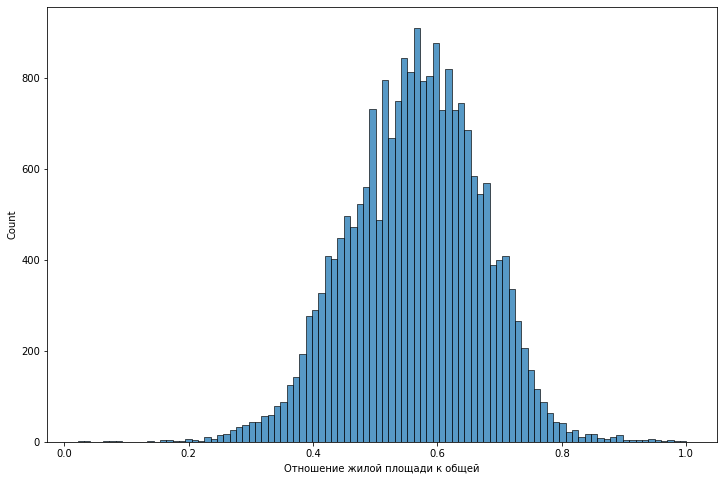

In [30]:
sns.histplot(data=df, x="living_area_ratio").set_xlabel(
    "Отношение жилой площади к общей"
);

В принципе, если будет необходимость заполнять пропуски в жилой площади, то можно воспользоваться медианой этого отношения.

Вычислим и отношение площади кухни к общей площади:

In [31]:
df["kitchen_area_ratio"] = df["kitchen_area"] / df["total_area"]
df["kitchen_area_ratio"].describe()

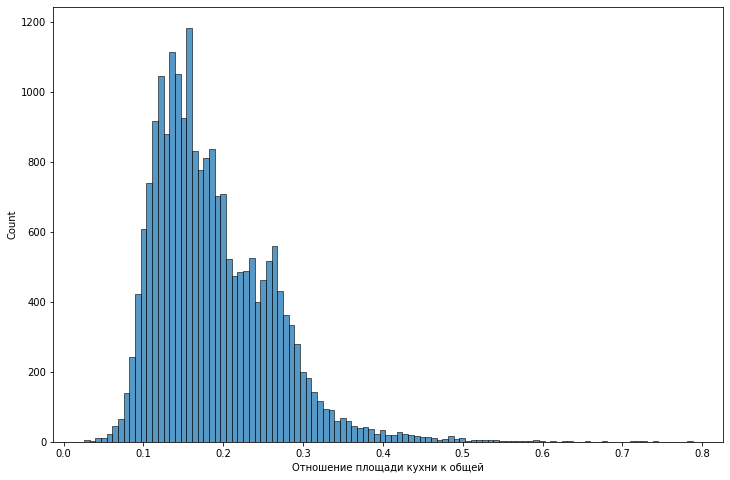

In [32]:
sns.histplot(data=df, x="kitchen_area_ratio").set_xlabel(
    "Отношение площади кухни к общей"
);

Видно, что это распределнение уже не очень похоже на гауссовское, да ещё имеет признаки двумодальности (видимо, у квартир разной площади разная доля приходится на кухню). 

Ещё одним полезным показателем может быть отношение площади кухни к нежилой площади квартиры:

In [33]:
df["kitchen_to_non_living_area_ratio"] = df["kitchen_area"] / (
    df["total_area"] - df["living_area"]
)
df["kitchen_to_non_living_area_ratio"].describe()

Очень интересно: существуют квартиры у которых площадь кухни **в разы** больше нежилой площади. Как так?!

In [34]:
df.loc[
    df["kitchen_to_non_living_area_ratio"] >= 1, "kitchen_to_non_living_area_ratio"
].describe()

Подобных объявлений нашлось 129 штук и выглядят они весьма подозрительно

#### Вывод

Вычислили полезные параметры "отношеие жилой площади к общей", "отношение площади кухни к общей" и "отношение площади кухни к нежилой". 

Это, в частности, позволило выявить неочевидные странности в данных: у ряда квартир площадь кухни больше площади нежилых помещений, что абсурдно. Тут на лицо ошибка, либо обман.

### Этажность

Ещё один существенный показатель, описывающий квартиру &mdash; её этаж. Причём, он важен не только сам по себе, но и в соотношении с этажностью дома: для многих нежелательными, а то и неприемлемыми являются варианты первого и последнего этажей. Если в номерах этажей (`floor`) пропусков нет, то во `floors_total` пропуски имеются, хотя и не много: 86

Посмотрим этажность представленную в данных и этажи в домах с неизвестной этажностью.  

In [35]:
df.loc[~df["floors_total"].isna(), "floor"].describe()  # .value_counts()

In [36]:
df.loc[df["floors_total"].isna(), "floor"].describe()

Видно, что распределения квартир в домах с известной и с неизвестной этажностью сильно различаются: судя по среднему в первом случае средний этаж чуть более 5, видимо, большинство квартир первой группы &mdash; "хрущёвки", тогда как у второй группы среднее равно 10. 

С другой стороны интересно, что это распределение совпадает с распределением домов по этажности: 

In [37]:
df["floors_total"].describe()

Это даёт основание предположить, что неуказанная этажность означает, что продавцы квартир пытались скрыть факт, что это последний этаж. На основание этого предположения можно заполнить пропуски:

In [38]:
df["floors_total"] = np.where(
    df["floors_total"].isna(), df["floor"], df["floors_total"]
)

df["floors_total"].isna().sum()

За одно приведём тип столбца к целому:

In [39]:
df["floors_total"] = df["floors_total"].astype("int")

#### Вывод

Мы заполнили пропущенную этажность домов в объявлениях, предположив, что авторы объявлений пытались скрыть, что квартира находится на последнем этаже. Тип этажности дома приведён к целому.

### Расстояние до центра Санкт-Петербурга и аэропорта

Рассмотрим такие географические параметры, предоставляемые Яндексом, как `airports_nearest`, `cityCenters_nearest`, `ponds_nearest`, `ponds_around3000`, `parks_nearest`, `parks_around3000`. Начнём с первых двух.

Видно, что количество пропусков довольно близко. 

Если посмотреть на максимальные значения расстояний до аэропорта и центра Санкт-Петербурга, то они весьма велики:

In [40]:
df.cityCenters_nearest.max(), df.airports_nearest.max()

Очевидно, что ограничений по расстоянию нет, как в случае ближайших парков и водоёмов (см. раздел "Праки и пруды"). Для удобства дальнейшего анализа введём новый признак: `cityCenters_defined`, который принимает значение `False`, если `cityCenters_nearest` не определено (`NaN`) и `True` &mdash; для определённых значений.

In [41]:
df["cityCenters_defined"] = np.where(df["cityCenters_nearest"].isna(), False, True)

Создадим сводную таблицу, в которой для разных населённых пунктов будем подсчитывать количество объявлений с определённым и неопределённым расстоянием до центра Санкт-Петербурга:

In [42]:
locality_unknown_geo = df[
    ["total_images", "locality_name", "cityCenters_defined"]
].pivot_table(
    index="locality_name", columns="cityCenters_defined", aggfunc="count", fill_value=0
)

Видно, что есть довольно много населённых пунктов, для которых вообще нет ни одного объявления с известным расстоянием до центра СПб

In [43]:
locality_unknown_geo[
    (locality_unknown_geo["total_images"][True] == 0)
    & (locality_unknown_geo["total_images"][False] > 0)
]

Эта неопределённость затрагивает 5386 объявлений

In [44]:
locality_unknown_geo[
    (locality_unknown_geo["total_images"][True] == 0)
    & (locality_unknown_geo["total_images"][False] > 0)
]["total_images"][False].sum()

Похоже, у Яндекса просто нет данных об этих населённых пунктах. В теории, можно было бы воспользоваться справочниками, чтобы восстановить недостающие данные хотя бы приблизительно: как кратчайшее расстояние между центрами СПб и этих населённых пунктов. Но это будет непростое дело: нужно извлечь информацию о 336 населённых пункта. Возможно, это задача для команды Data Engineers.

Сейчас же перед нами стоит задача заполнить пропуски и привести столбцы к адекватным типам, чему мешают пропуски. В данной ситуации мы можем воспользоваться заполнителем в виде "невозможного" значения, например -1 (и расстояния и количества объектов должны быть неотрицательными), которое будет аналогом "Unknown" для названий населённых пунктов. Этот заполнитель можно применить и к параметрам `cityCenters_nearest`, `airports_nearest`, а также к `ponds_nearest`, `ponds_around3000`, `parks_nearest`,`parks_around3000`. 

Легко убедиться, что, если не известно расстояние до аэропорта и центра СПб, не известно и всё остальное:

In [45]:
df[
    df["cityCenters_nearest"].isna()
    & df["airports_nearest"].isna()
    & (
        ~df["ponds_nearest"].isna()
        | ~df["ponds_around3000"].isna()
        | ~df["parks_nearest"].isna()
        | ~df["parks_around3000"].isna()
    )
].shape[0]

Эти пропуски (во всех 6 столбцах) заполним нашим заполнителем -1:

In [46]:
df.loc[
    df["cityCenters_nearest"].isna() & df["airports_nearest"].isna(),
    [
        "cityCenters_nearest",
        "airports_nearest",
        "ponds_nearest",
        "ponds_around3000",
        "parks_nearest",
        "parks_around3000",
    ],
] = -1

df[df["cityCenters_nearest"].isna() & df["airports_nearest"].isna()].shape[0]

In [47]:
(
    df[df["cityCenters_nearest"].isna() & ~df["airports_nearest"].isna()].shape[0],
    df[~df["cityCenters_nearest"].isna() & df["airports_nearest"].isna()].shape[0],
)

Есть несколько объявлений (все в СПб) для которых не известно либо расстояние до центра города, либо расстояние до аэропорта (1 и 24 шт, соответственно). При этом остальные географические параметры определены. Их немногочисленность наводит на мысль о сбое. Для этих объявлений заполним пропуски в расстояниях `cityCenters_nearest` и `airports_nearest` значением -1, но оставим без изменений остальные параметры.

In [48]:
df.loc[
    df["cityCenters_nearest"].isna() & ~df["airports_nearest"].isna(),
    "cityCenters_nearest",
] = -1
df.loc[
    ~df["cityCenters_nearest"].isna() & df["airports_nearest"].isna(),
    "airports_nearest",
] = -1

In [49]:
df[["cityCenters_nearest", "airports_nearest"]].isna().sum()

Мы заполнили все пропуски и можем привести столбцы к целочисленному виду: все расстояния даны с точностью до километра:

In [50]:
df[["cityCenters_nearest", "airports_nearest"]] = df[
    ["cityCenters_nearest", "airports_nearest"]
].astype("int")

#### Вывод

Мы столкнулись с ситуацией, когда не можем заполнить пропуски в географической информации какими-то осмысленными значениями. Поэтому мы ввели заполнитель смысла "Unknown", которйы будет просто сигнализировать, что значение не определено. Такая замена позволила нам исправить типы столбцов на целые.

### Парки и пруды

Рассмотрим теперь данные, касающихся окрестных парков и прудов: `parks_nearest`, `ponds_nearest` и `parks_around3000`, `ponds_around3000`.

Легко видеть, что там, где нет сведений о расстоянии до ближайшего объекта, нет и количества объектов в 3 км вокруг квартиры:

In [51]:
(
    df[~df["parks_nearest"].isna() & df["parks_around3000"].isna()].shape[0],
    df[~df["ponds_nearest"].isna() & df["ponds_around3000"].isna()].shape[0],
)

С другой стороны, есть ситуации, когда количество прудов и парков в 3-км окрестности определено (не NaN), но расстояние до ближайшего не определено:

In [52]:
(
    df[df["parks_nearest"].isna() & ~df["parks_around3000"].isna()].shape[0],
    df[df["ponds_nearest"].isna() & ~df["ponds_around3000"].isna()].shape[0],
)

Видно, что все эти случаи соответствуют ситуации, когда в 3-км окрестности объектов нет:

In [53]:
(
    df[df["parks_nearest"].isna() & (df["parks_around3000"] == 0)].shape[0],
    df[df["ponds_nearest"].isna() & (df["ponds_around3000"] == 0)].shape[0],
)

In [54]:
df["parks_nearest"].max(), df["ponds_nearest"].max()

Похоже, если расстояние до ближайшего объекта известно и превышает 3 км (или чуть больше), то параметры `parks_nearest`, `ponds_nearest` не передаются. В таком случае для заполнения пропусков можно использовать число-заполнитель заведомо больше порога, положенного Яндексом. Например, 10 000 м или `np.inf`. Недостатком второго варианта является то, что `np.inf` &mdash; это вещественное значение, которое не удастся в дальнейшем привести к целому типу.

Таким образом у параметров `ponds_nearest` и `parks_nearest` будет два заполнителя с разным смыслами: 10 000 указывает, что расстояние известно, но слишком велико, а `-1` &mdash; что расстояние не известно (может озачать и "парк под окнами" и "ближайший парк в соседнем городе").

In [55]:
df[
    ["parks_nearest", "ponds_nearest", "parks_around3000", "ponds_around3000"]
].isna().sum()

In [56]:
df["parks_nearest"] = np.where(df["parks_around3000"] == 0, 10_000, df["parks_nearest"])
df["ponds_nearest"] = np.where(df["ponds_around3000"] == 0, 10_000, df["ponds_nearest"])

In [57]:
df[
    ["parks_nearest", "ponds_nearest", "parks_around3000", "ponds_around3000"]
].isna().sum()

Теперь, когда все пропуски заполнены, мы можем привести признаки `parks_nearest`, `ponds_nearest`, `parks_around3000` и `ponds_around3000` к целому виду: количество парков/прудов не может быть вещественным по смыслу, а расстояния до ближайших объектов измеряется всюду в целых метрах.

In [58]:
df = df.astype(
    {
        "parks_around3000": "int",
        "ponds_around3000": "int",
        "parks_nearest": "int",
        "ponds_nearest": "int",
    }
)

In [59]:
df.dtypes

#### Вывод

Мы заполнили все пропуски, какие смогли и присвоили всем столбцам таблицы осмысленные типы. Теперь рассчитаем ряд полезных параметров квартир, которые помогут дальнейшему анализу

## Расчёты и добавление результатов в таблицу

Мы уже добавили в таблицу такие столбцы как `m2_price` (цена квадратного метра) см. раздел "высота потолка", `living_area_ratio` (отношение жилой площади к общей), `kitchen_area_ratio` (отношение площади кухни к общей), `kitchen_to_non_living_area_ratio` (отношение площади кухни к площади нежилых помещений) в разделе "Соотношения площадей недвижимости".



Развернём в отдельные колонки данные о датах покупки: дне недели, месяце и годе публикации, а также превратим информацию об этаже в категорию: первый, последний, другой.

In [60]:
df["first_day_exposition_weekday"] = df["first_day_exposition"].dt.weekday
df["first_day_exposition_month"] = df["first_day_exposition"].dt.month
df["first_day_exposition_year"] = df["first_day_exposition"].dt.year

С категоризацией этажа имеется небольшая неопределённость: единственный этаж одноэтажного дома считать первым или последним? К счастью, это не принципиально с учётом мизерности выборки

In [61]:
df[df["floors_total"] == 1].shape[0]

In [62]:
df["floor_category"] = "другой"
df["floor_category"] = np.where(
    df["floors_total"] == df["floor"], "последний", df["floor_category"]
)
df["floor_category"] = np.where(df["floor"] == 1, "первый", df["floor_category"])
df["floor_category"].value_counts()

Приведём новую колонку к категориальному виду:

In [63]:
floor_category = pd.api.types.CategoricalDtype(
    categories=["первый", "другой", "последний"], ordered=True
)
df["floor_category"] = df["floor_category"].astype(floor_category)
df["floor_category"].head()

### Вывод

Мы вывели в отдельные колонки информацию о днях недели, месяцах и годах, в которые были опубликованы объявления для целей дальнейшего анализа. Также мы создали категорию связанную с этажём, на котором расположена квартира: первый, другой, последний. 

## Исследовательский анализ данных

### Параметры квартир

Исследуем для начала такие ключевые признаки недвижимости как площадь, цена, число комнат, высота потолков

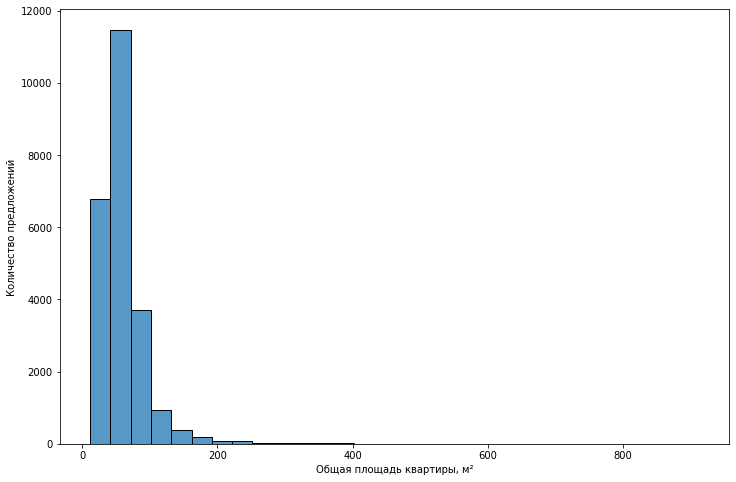

In [64]:
ax = sns.histplot(data=df, x="total_area", binwidth=30)
ax.set_xlabel("Общая площадь квартиры, м²")
ax.set_ylabel("Количество предложений");

Разброс цен весьма велик, немногочисленная группа особо дорогих квартир смазывают всю картину, так что сделаем два графика: один отображает всю картину, прижимая недорогое большинство к началу координат и более подробный график для большинства

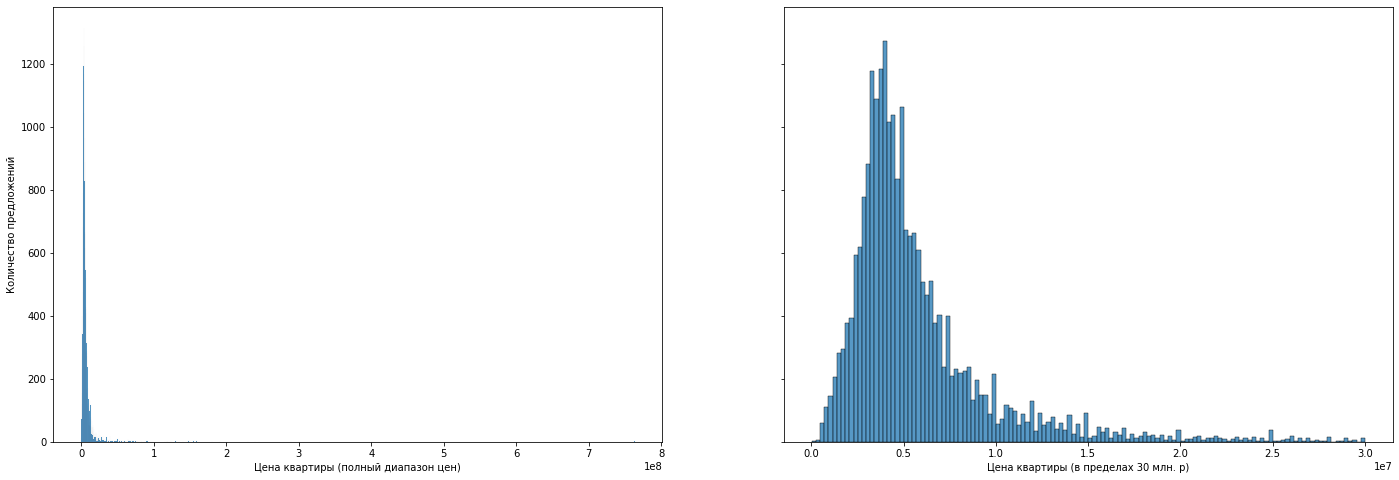

In [65]:
fig, ax = plt.subplots(1, 2, figsize=(24, 8), sharey=True)

sns.histplot(ax=ax[0], data=df, x="last_price")
ax[0].set_xlabel("Цена квартиры (полный диапазон цен)")
ax[0].set_ylabel("Количество предложений")

sns.histplot(ax=ax[1], data=df[df["last_price"] < 3e7], x="last_price")
ax[1].set_xlabel("Цена квартиры (в пределах 30 млн. р)")
ax[1].set_ylabel("Количество предложений");

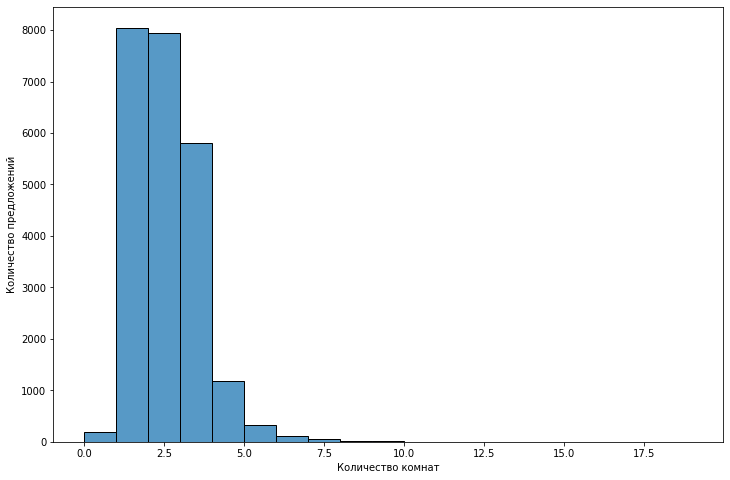

In [66]:
ax = sns.histplot(data=df, x="rooms", binwidth=1)
ax.set_xlabel("Количество комнат")
ax.set_ylabel("Количество предложений");

Все три графика выглядят как типичная пуассоновская кривая.

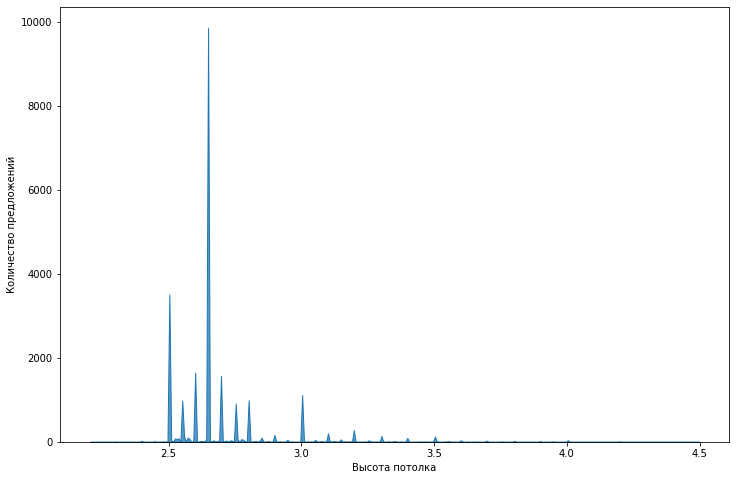

In [67]:
ax = sns.histplot(
    data=df[(df["ceiling_height"] <= 4.5) & (df["ceiling_height"] > 2)],
    x="ceiling_height",
    element="poly",
)  # , binwidth=0.5)
ax.set_xlabel("Высота потолка")
ax.set_ylabel("Количество предложений");

Значения высот потолков, если смотреть по огибающей также похоже на пуассоновскую кривую. Но имеет и свои особенности: прежде всего, гистограмма не является "заполненной", на ней имеется "гребёнка" отстоящих друг от друга популярных значений высот потолков, зазор между которыми заполняют редкие варианты. 

Скорее всего, гребёнка из "мод" &mdash; это типовые значения из наиболее популярных проектов домов (СССР, ГОСТ и всё такое). А редкие значения &mdash; это, например, результат инбивидуальных переделок, а также экзотические проекты, например, очень старые или наоборот, новые, нетиповые.

#### Вывод

Мы построили гистограммы для таких признаков как площадь квартиры, её цена и количество комнат. Все эти графики имеют сходный вид: они ограничены слева, имеют ярко выраженную моду и длинный правый хвост. Иначе выглядит график высоты потолка: на нём ярко выделяются типовые значения на фоне экзотики.  

### Параметры продаж

Важной мерой сделок является, время с момента выставления объявления до продажи. Хотелось бы определить характерное время средней продажи и границы нормы 

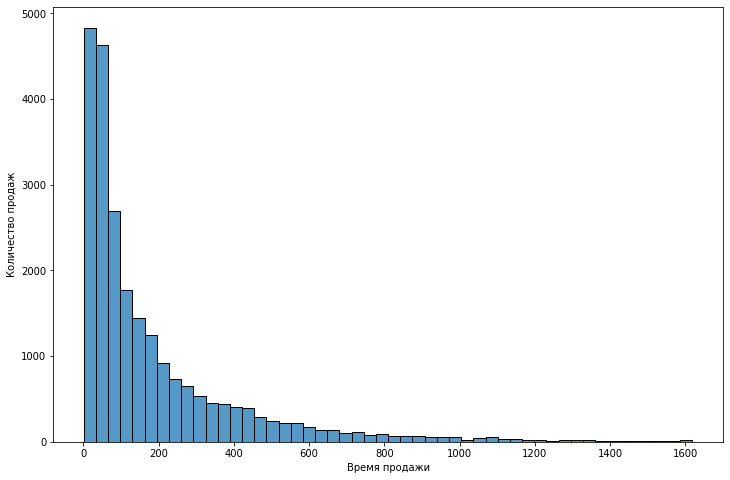

In [68]:
ax = sns.histplot(data=df, x="days_exposition", bins=50)
ax.set_xlabel("Время продажи")
ax.set_ylabel("Количество продаж");

Поскольку кривая явно негауссова и имеет длинный правый хвост, такая мера как среднее будет давать существеенный перекос вправо (по факту, среднее превышает медиану вдвое):

In [69]:
df["days_exposition"].agg(["mean", "median"])

Таким образом, наиболее адекватной мерой типовой сделки будет считать медиану по времени экспозиции объявления. Чтобы очертить "границы нормы" можно использовать логику, используемую в графиках barplot: основное ядро дежит между внутри второй и третьей квартилей (50% всех сделок), а периферийя простирается на 1,5 размажа за их пределы. 

Недостатком этого метода является нечувствительность аномально быстрым сделкам: левая граница нормы гарантировано упрётся в 0.

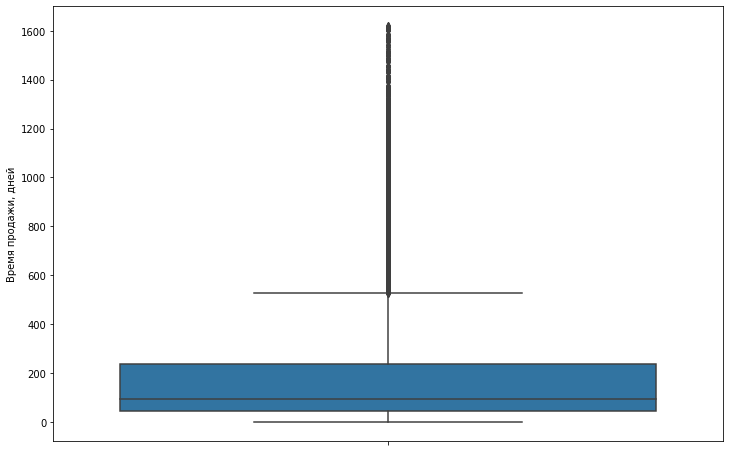

In [70]:
ax = sns.boxplot(data=df, y="days_exposition")
ax.set_ylabel("Время продажи, дней");

In [71]:
df["days_exposition"].describe()

Поэтому разумнее выбрать более консервативный подход, например, распространяющий норму только на вторую и третью крвартили. Недостатком этого подхода станет то, что под подозрение автоматически попадут 50% сделак, что вряд ли правильно.

Учитывая длинный правый хвост зависимости можно скомбинировать два педыдущих метода: слева ограничиться второй квартилью, а справа добавить к третьей полуторный размах $IQR$, что даст нам границы нормы между 43 и 528 днями. В этот интервал попадает 15755 сделок, что составляет 66% от общего числа. 5978 сделок (25%) можно считать подозрительно быстрыми, а 1966 (8%) &mdash; аномально медленными.

In [72]:
x = df[(df["days_exposition"] > 43) & (df["days_exposition"] < 528)].shape[0]
x, x / df.shape[0]

In [73]:
x = df[df["days_exposition"] <= 43].shape[0]
x, x / df.shape[0]

In [74]:
x = df[df["days_exposition"] >= 528].shape[0]
x, x / df.shape[0]

Если отбросить самые медленные из сделок, мы получим следующее распределение:

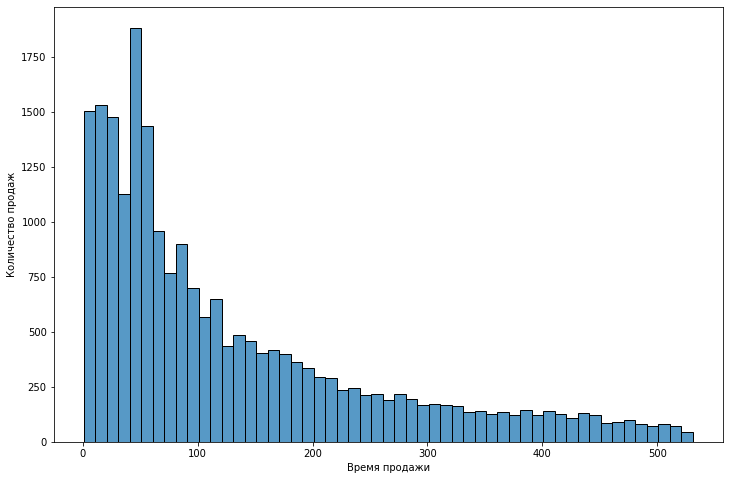

In [75]:
ax = sns.histplot(
    data=df[(df["days_exposition"] < 528)], x="days_exposition", binwidth=10
)
ax.set_xlabel("Время продажи")
ax.set_ylabel("Количество продаж");

Прежде всего, видно, что в области малых времён у нас есть ярко выраженная мода с окресностях 50 дней, а также аномальный подъём: такое количество быстрых сделок (в пределах 30 дней) действительно выглядит аномально.

Остальной график выглядит более-менее гладкой пуассоновской кривой на которой выделяется некоторое количество выбросов в окрестностях 50, 90, 120 дней. Дальше пики не просматриваются, скрываясь на фоне гладкой кривой.

В области длинных сделок особо ничего интересного не просматривается. Там всё гладко и спокойно: либо дорогая, а потому эксклюзивная недвижимость ждёт своего покупателя, либо продавцы выставили неадекватно высокие ценники, но упрямо продолжают ждать переезда в Спб персидских шейхов. 

#### Вывод

Мы ограничили нормальные сделки по длительности и в области быстрых сделок обнаружили аномально большое колличество сделок. Эту аномалию стоит изучить более внимательно. 

In [76]:
# КОД РЕВЬЮЕРА

df[["last_price", "total_area", "rooms", "ceiling_height"]].describe().loc[
    ["min", "max"]
]

### Факторы стоимости квартиры

Рассмотрим факторы, влияющие на стоимость квартиры. Исходя из здравого смысла, в число наиболее значимых входят следующие: площадь, число комнат, удалённость от
центра. Также интересно изучить зависимость цены от того, на каком этаже расположена квартира (первый, последний, другой) и от даты размещения: дня недели, месяца и года.

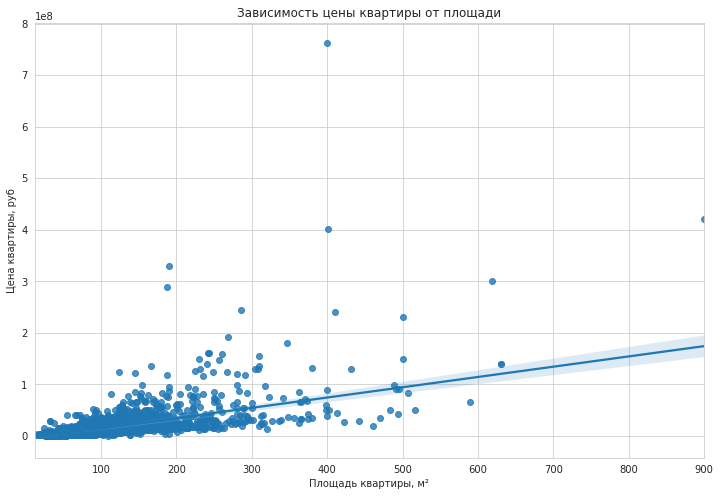

In [121]:
ax = sns.regplot(data=df, x="total_area", y="last_price")
ax.set_title("Зависимость цены квартиры от площади")
ax.set_xlabel("Площадь квартиры, м²")
ax.set_ylabel("Цена квартиры, руб");

In [126]:
price_lr = LinearRegression().fit(
    X=np.array(df["total_area"]).reshape((-1, 1)), y=df["last_price"]
)
print(f"Коэффициент регрессии: {price_lr.coef_[0]:.2f}")

Коэффициент регрессии указывает на угол наклона прямой, проходящей через множество измерений (в данном случае пар "площадь-цена"). В данном случае мы видим, что прирост площади квартиры на 1 м² приводит, в среднем, к приросту цены на 200 тысяч рублей. 

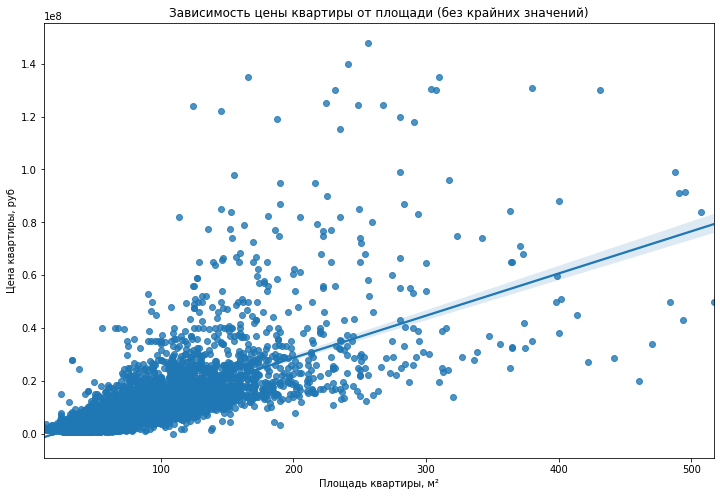

In [78]:
ax = sns.regplot(
    data=df[(df["total_area"] < 550) & (df["last_price"] < 1.5e8)],
    x="total_area",
    y="last_price",
)
ax.set_title("Зависимость цены квартиры от площади (без крайних значений)")
ax.set_xlabel("Площадь квартиры, м²")
ax.set_ylabel("Цена квартиры, руб");

Видно, что основная масса квартир тяготеют к некоей прямой, хотя есть и довольно рыхлое облако точек, отстоящиих от нашей регрессионной кривой довольно далеко. А некоторые и очень далеко. Впрочем, расстояние от регрессионной кривой тоже можно рассматривать как признак ценовой аномалии.

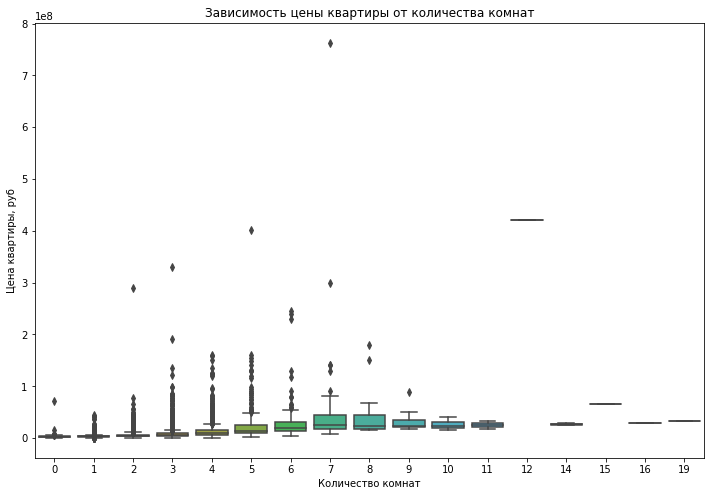

In [79]:
ax = sns.boxplot(data=df, x="rooms", y="last_price")
ax.set_title("Зависимость цены квартиры от количества комнат")
ax.set_xlabel("Количество комнат")
ax.set_ylabel("Цена квартиры, руб");

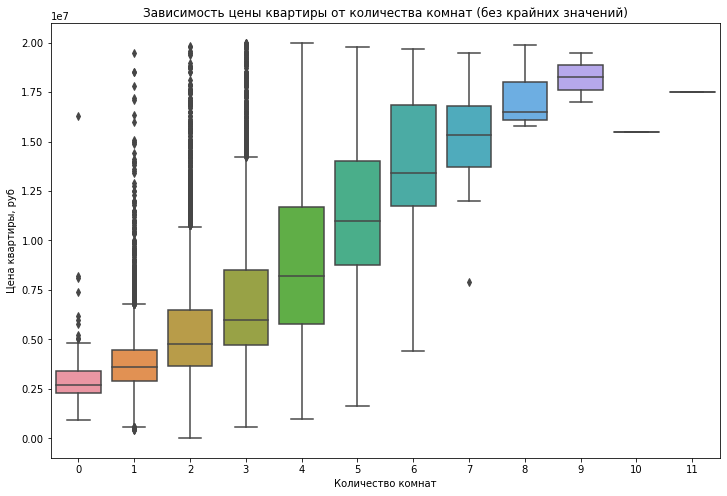

In [80]:
ax = sns.boxplot(data=df[df["last_price"] < 2e7], x="rooms", y="last_price")
ax.set_title("Зависимость цены квартиры от количества комнат (без крайних значений)")
ax.set_xlabel("Количество комнат")
ax.set_ylabel("Цена квартиры, руб");

Глядя на графики, можно заметить, что в области небольшого числа комнать наблюдается монотонный рост цен на недвижимость, вплоть до 9 комнат. Дальше происходит насыщение: прирост числа комнат не приводит к заметному росту цены. Это может быть связано, помимо прочего, с редкостью подобных предложений и, как сделствие, неоднородности цен.

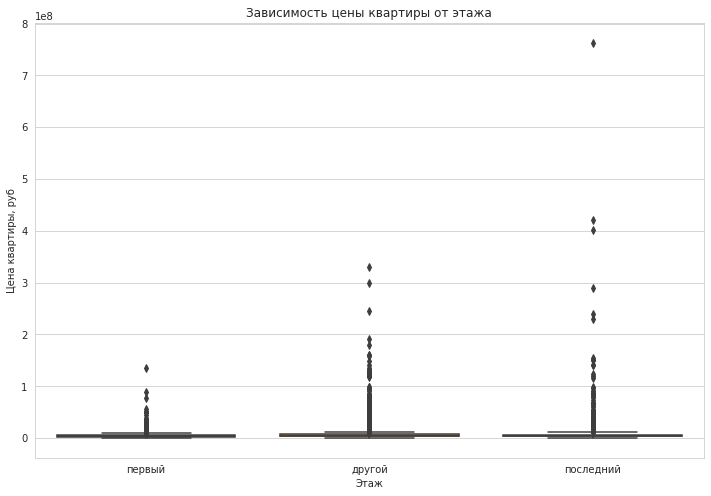

In [137]:
ax = sns.boxplot(data=df, x="floor_category", y="last_price")
ax.set_title("Зависимость цены квартиры от этажа")
ax.set_xlabel("Этаж")
ax.set_ylabel("Цена квартиры, руб");

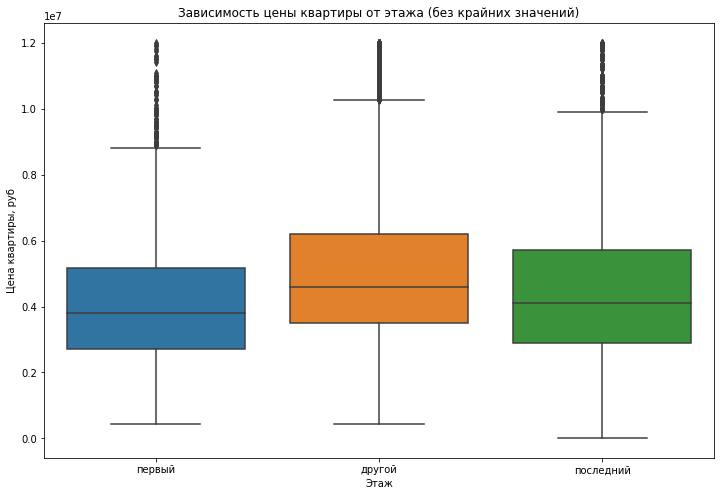

In [82]:
ax = sns.boxplot(data=df[df["last_price"] < 1.2e7], x="floor_category", y="last_price")
ax.set_title("Зависимость цены квартиры от этажа (без крайних значений)")
ax.set_xlabel("Этаж")
ax.set_ylabel("Цена квартиры, руб");

График показывает, что квартиры на первом и последнем этажах действительно дисконтируются по сравнеию с остальными. Разница между первым и последним, если есть в среднем, то не значительна. 

Чем выделяются квартиры на последнем этаже, так это большим выбросом в область эестремально высоких цен: очевидно, это влияние того самого пентхауса.

In [83]:
df[["first_day_exposition_weekday"]].info()

In [84]:
weekdays = [
    "Понедельник",
    "Вторник",
    "Среда",
    "Четверг",
    "Пятница",
    "Суббота",
    "Воскресенье",
]

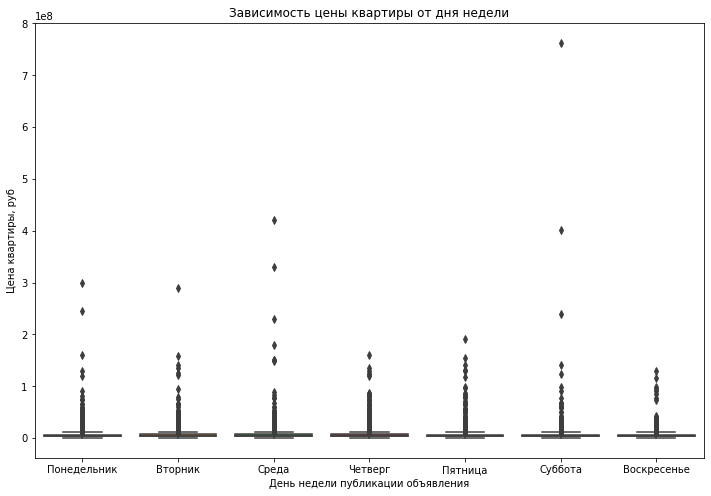

In [85]:
ax = sns.boxplot(data=df, x="first_day_exposition_weekday", y="last_price")
ax.set_xticklabels(weekdays)
ax.set_title("Зависимость цены квартиры от дня недели")
ax.set_xlabel("День недели публикации объявления")
ax.set_ylabel("Цена квартиры, руб");

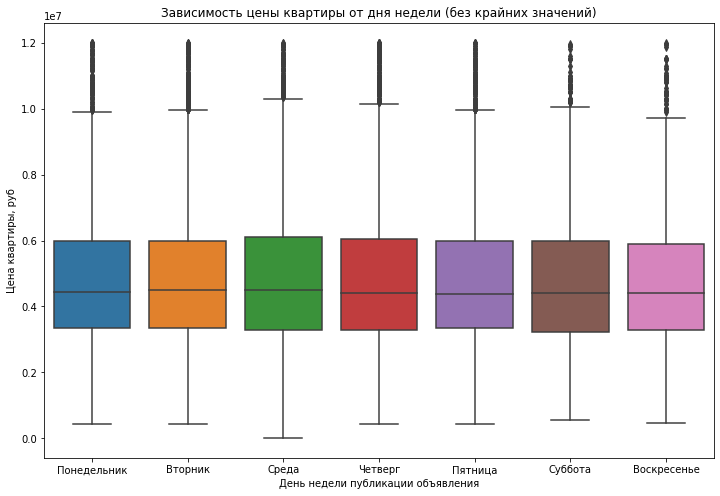

In [86]:
ax = sns.boxplot(
    data=df[df["last_price"] < 1.2e7], x="first_day_exposition_weekday", y="last_price"
)
ax.set_xticklabels(weekdays)
ax.set_title("Зависимость цены квартиры от дня недели (без крайних значений)")
ax.set_xlabel("День недели публикации объявления")
ax.set_ylabel("Цена квартиры, руб");

Сколько-нибудь выраженной зависимость цены (без учёта выбросов) от дня недели не заметно.

In [87]:
month = [
    "Январь",
    "Февраль",
    "Март",
    "Апрель",
    "Май",
    "Июнь",
    "Июль",
    "Август",
    "Сентябрь",
    "Октябрь",
    "Ноябрь",
    "Декабрь",
]

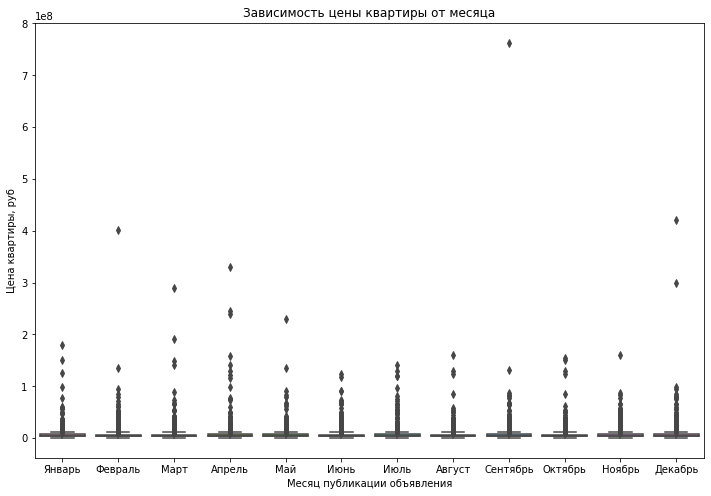

In [88]:
ax = sns.boxplot(data=df, x="first_day_exposition_month", y="last_price")
ax.set_xticklabels(month)
ax.set_title("Зависимость цены квартиры от месяца")
ax.set_xlabel("Месяц публикации объявления")
ax.set_ylabel("Цена квартиры, руб");

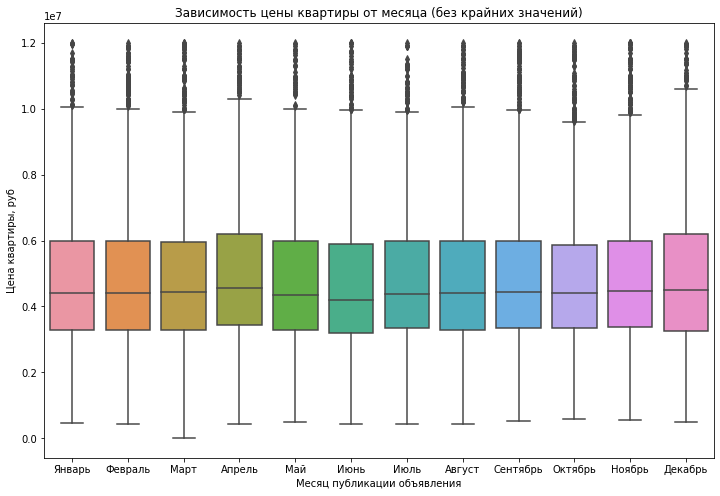

In [89]:
ax = sns.boxplot(
    data=df[df["last_price"] < 1.2e7], x="first_day_exposition_month", y="last_price"
)
ax.set_xticklabels(month)
ax.set_title("Зависимость цены квартиры от месяца (без крайних значений)")
ax.set_xlabel("Месяц публикации объявления")
ax.set_ylabel("Цена квартиры, руб");

Заметныйх различий между месяцами выявить не удаётся. Выбросы есть, но на то они и выбросы, что это разовые эксклюзивные события.

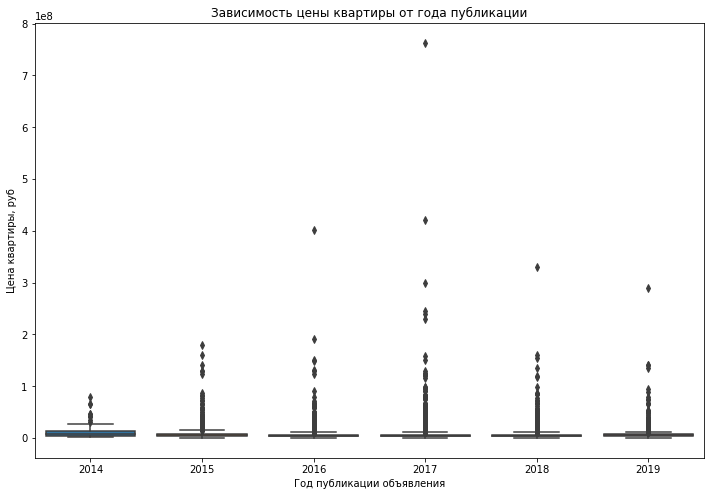

In [90]:
ax = sns.boxplot(data=df, x="first_day_exposition_year", y="last_price")
ax.set_title("Зависимость цены квартиры от года публикации")
ax.set_xlabel("Год публикации объявления")
ax.set_ylabel("Цена квартиры, руб");

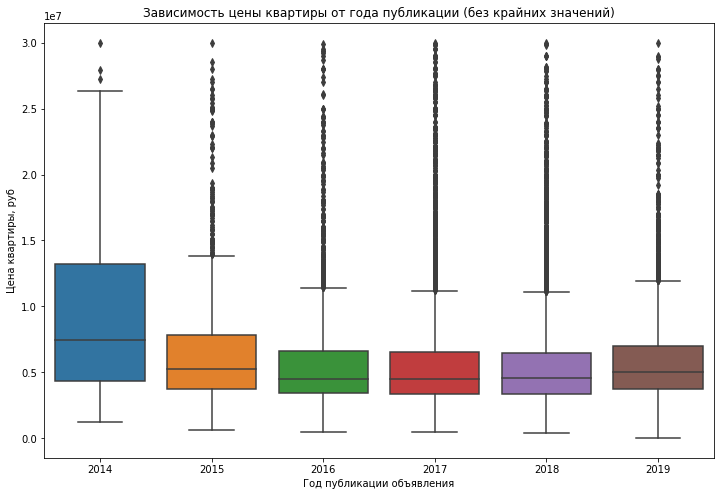

In [91]:
ax = sns.boxplot(
    data=df[df["last_price"] < 3e7],
    x="first_day_exposition_year",
    y="last_price",
)
ax.set_title("Зависимость цены квартиры от года публикации (без крайних значений)")
ax.set_xlabel("Год публикации объявления")
ax.set_ylabel("Цена квартиры, руб");

По годам динамика хорошо заметна: наибольшую медианную цену и наибольший $IQR$ продемонстрировал 2014 год. Далее, очевидно, по макроэкономическим причином произошла заметная просадка. На 2016-2018 приходится некоторое плато, характеризуемое практически неизменной медианой и $IQR$. 2019 год показал заметный рост по обоим показателям.

#### Вывод

Мы исследовали факторы, влияющие на цену недвижимости: 
- общая пложадь кавартиры, предсказуемо влияет;
- тоже можно сказать и о количестве комнат, по крайней мере, если комнат не более 9;
- влияние этажа имеется, но не очень значительное в среднем;
- месяц выставления объявления никак не повлиял на цену: сезонность в ценах недвижимости не просматривается;
- год публикации объявления оказался более важен.

### Населённые пункты и цена недвижимости

Посмотрим, из каких населённых пунктов поступило больше всего объявлений:

In [92]:
localities = pd.Series(df["locality_name"].value_counts().head(10).index)

In [93]:
localities

In [94]:
df[df["locality_name"].isin(localities)].groupby("locality_name").agg(
    {"m2_price": "mean"}
).sort_values(by="m2_price", ascending=False)

Предсказуемо самый дорогой квадратный метр в Санкт-Петербурге, а самый дешёвый &mdash; в сравнительно крупном, но далёком от СПб Выборге.

#### Вывод

Удельная цена недвижимости варьируется между населёнными пунктми. Наиболее вастребованы квартиры в Санкт-Петербурге. Далее по мере уменьшения масштаба населённого пункта и его удаления от СПб, цены падают.

### Цены внутри Санкт-Перербурга

В большинстве городов цены распределены не равномерно: более низкие в спальных раёонах на периферии и более высокие в центре. Узнаем какую часть города петербуржцы считают центральной 

In [95]:
df["spb_center_km"] = np.around(df["cityCenters_nearest"] / 1000)
df["spb_center_km"] = df["spb_center_km"].astype("int")

In [96]:
spb_m2_price = (
    df[(df["locality_name"] == "Санкт-Петербург") & (df["cityCenters_nearest"] > 0)]
    .groupby("spb_center_km")
    .agg({"m2_price": "mean"})
)

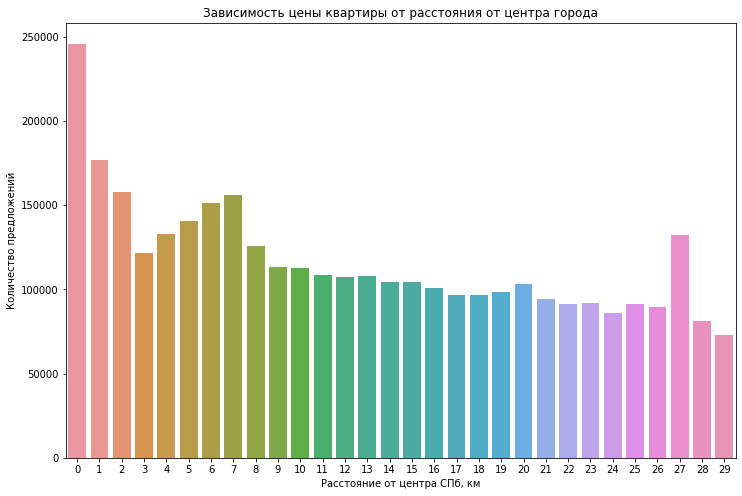

In [97]:
ax = sns.barplot(x=spb_m2_price.index, y=spb_m2_price["m2_price"])
ax.set_title("Зависимость цены квартиры от расстояния от центра города")
ax.set_xlabel("Расстояние от центра СПб, км")
ax.set_ylabel("Количество предложений");

#### Вывод

Центр СПб с аномально высокими ценами на недвижимость оказался на удивления небольшим: менее 3 км. 

В районе 7 км наблюдается ещё одна ценовая аномалия, видимо на таком расстоянии от центра находится какой-то престижный район города, но это вопрос к людям лучше разбирающимся в географии города.

### Квартиры в центре Санкт-Петербурга

Проанализируем теперь квартиры в центре Санкт-Петербурга и посмотрим, чем эта недвижимость отличается от широкой выборки. Для удобства дальнейшего анализа соберём нужные квартиры в отдельный дата-фрейм

In [98]:
df_spb_center = df[(df["spb_center_km"] < 3) & (df["cityCenters_nearest"] > 0)]
df_spb_center.describe()

Для сравнения можно посмотреть на статистику по всем объявлениям СПб:

In [147]:
df[df['locality_name']=="Санкт-Петербург"].describe()

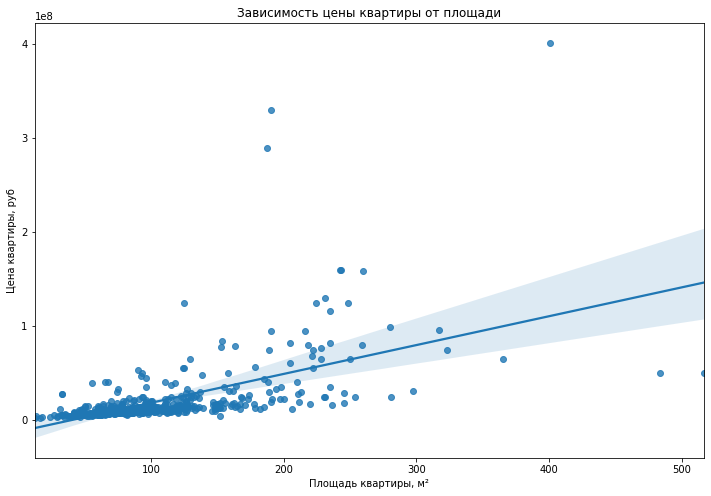

In [99]:
ax = sns.regplot(data=df_spb_center, x="total_area", y="last_price")
ax.set_title("Зависимость цены квартиры от площади")
ax.set_xlabel("Площадь квартиры, м²")
ax.set_ylabel("Цена квартиры, руб");

В целом, характер зависимости цены квартиры от её площади сходно с тем, что мы видели на широкой выборке. Но уже по графику видно, что угол наклона регрессионой прямой заметно больше. Вычисления подтверждают, что это так: прирост площади квартиры на 1 м² приводет, в среднем, к росту цены на 300 тысяч рублей.

In [127]:
center_price_lr = LinearRegression().fit(
    X=np.array(df_spb_center["total_area"]).reshape((-1, 1)),
    y=df_spb_center["last_price"],
)

print(f"Коэффициент регрессии: {center_price_lr.coef_[0]:.2f}")

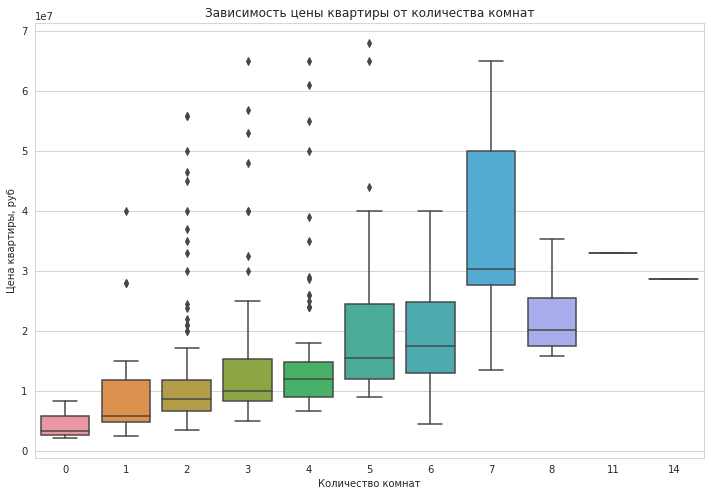

In [130]:
ax = sns.boxplot(
    data=df_spb_center[df_spb_center["last_price"] < 0.7e8], x="rooms", y="last_price"
)
ax.set_title("Зависимость цены квартиры от количества комнат")
ax.set_xlabel("Количество комнат")
ax.set_ylabel("Цена квартиры, руб");

Цены квартир более-менее равномерно растут с ростом количества комнат вплоть до 7. Из общей картины выбиваются 8-комнатные квартиры, цены которых примерно соответсвуют 6-комнатным. Возможно, дело просто в малой выборке: 8-комнатных квартир всего 4, да и 6-комнатных не очень много (23). Квартиры с большим количеством комнат рассматривать вообще бессмысленно: они представлены единичными экземплярами.

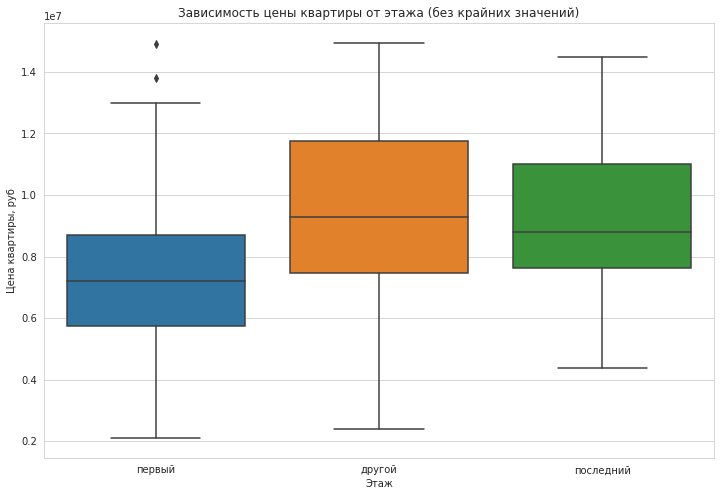

In [140]:
ax = sns.boxplot(
    data=df_spb_center[df_spb_center["last_price"] < 1.5e7],
    x="floor_category",
    y="last_price",
)
ax.set_title("Зависимость цены квартиры от этажа (без крайних значений)")
ax.set_xlabel("Этаж")
ax.set_ylabel("Цена квартиры, руб");

В центре СПб разница в цене квартир в зависимости от этажа более ярко выражена: наибольший дисконт предоставляется за квартиры еа первом этаже, эти квартиры заметно дешевне квартир на последнем (медиана проходит ниже "дна" зелёного бокса).

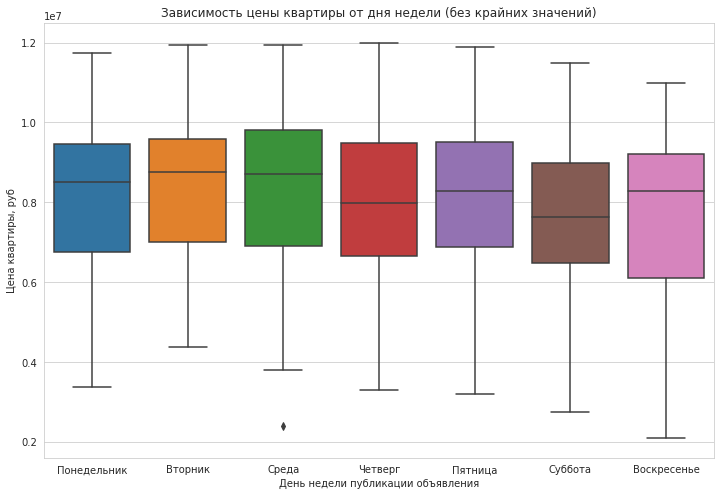

In [142]:
ax = sns.boxplot(
    data=df_spb_center[df_spb_center["last_price"] < 1.2e7],
    x="first_day_exposition_weekday",
    y="last_price",
)
ax.set_xticklabels(weekdays)
ax.set_title("Зависимость цены квартиры от дня недели (без крайних значений)")
ax.set_xlabel("День недели публикации объявления")
ax.set_ylabel("Цена квартиры, руб");

Сколько-нибудь выраженной зависимость цены (без учёта выбросов) от дня недели не заметно.

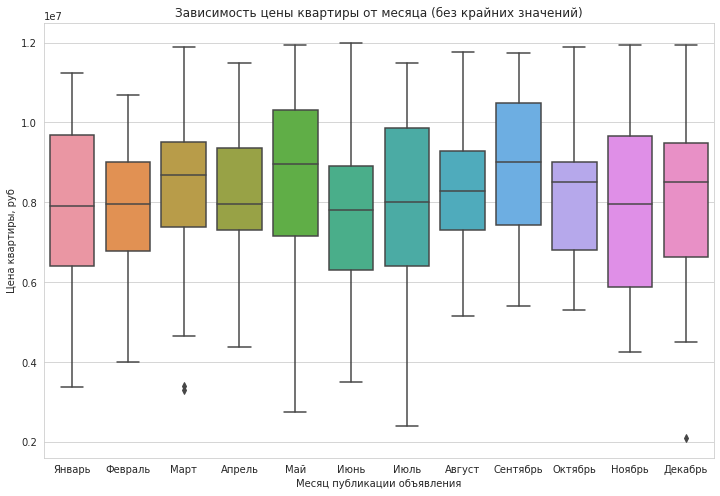

In [143]:
ax = sns.boxplot(
    data=df_spb_center[df_spb_center["last_price"] < 1.2e7],
    x="first_day_exposition_month",
    y="last_price",
)
ax.set_xticklabels(month)
ax.set_title("Зависимость цены квартиры от месяца (без крайних значений)")
ax.set_xlabel("Месяц публикации объявления")
ax.set_ylabel("Цена квартиры, руб");

Как и в широкой выборке, цены квартир в центре СПб не проявляют заметной сезонгности и не зависят от дня недели публикации объявления.

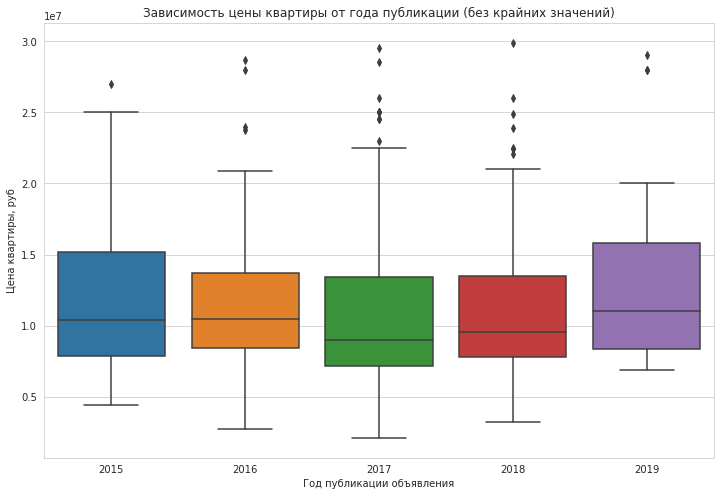

In [144]:
ax = sns.boxplot(
    data=df_spb_center[df_spb_center["last_price"] < 3e7],
    x="first_day_exposition_year",
    y="last_price",
)
ax.set_title("Зависимость цены квартиры от года публикации (без крайних значений)")
ax.set_xlabel("Год публикации объявления")
ax.set_ylabel("Цена квартиры, руб");

К сожалению, объявлений из центра СПб в 2014 году нет, так что подтвердить или опровергнуть тезис о высоких ценах для центра в 2014 году нет возможности. Что же касается последующих лет, то в отличте от широкой выборки, центр города не показал снижения цен в 2016 году в сравнении с 2015. средняя цена даже чуть поднялась, хоть и не значимо, наиболее заметное изменение &mdash; сужение разброса цен. Заметное падение в центре произошло, но затронуло всего один год &mdash; 2017. Но уже в 2018 и 2019 наблюдается поступательный рост.

#### Вывод

В целом, характер зависимостей между ценами и основными параметрами квартир в центре СПб и в широкой выборке сходны, хотя есть и нюансы. Так, средняя цена квартиры в центре выше, большей популярностью пользутся квартиры с б**о**льшим числом комнат и большей площадью. Меньше в центре разброс по значениям высоты потолков.

## Общий вывод

Мы изучили базу объявлений о продаже недвижимости в Санкт-Петербурге и окрестностях. 

Были выявлены параметры оказывающие наибольшее влияние на цену, прежде всего это площадь квартиры, количество комнат и населённый пункт: наибольшим спросом пользуется Санкт-Петербурга и ближайшие к нему крупные населённые пункты. Такие факторы, как день недели, месяц публикации объявления или этаж ощутимого влияния на цену не оказали.

В ходе анализа данных была выявлена аномалия в ряде объявлений, выраженная в том, что площадь кухни оказалась больше нежилой площади, что невозможно (кухня это часть нежилых помещений). Этьо может быть признаком умышленного искажения данных о предлагаемой на продажу недвижимости.

При изучении времени продажи квартир была выявлена аномально большая доля сделок, закрытых в течение месяца (не более 30 дней) при том, что медианное время &mdash; три месяца. С другой стороны, есть и очень долгие сделки, к каковым мы отнесли те, что длятся около полутора лет (528 дней) с пиковыми значениями, превышающими 4 года. Аномально высокое количество быстрых сделок может быть как результатом деятельности добросовестных продавцов, нуждающихся максимально быстро получить деньги, пусть и с дисконтом, так и результатом работы недобросовестных продавцов, которые, в массе, стермятся как можно быстрее получить деньги и исчезнуть.

Изучение данных по городу Санкт-Петербург показал, что в нём имеется компактная (с радиусом мене 3км) центральная часть, выделяющаяся на фоне остального города высокой ценой недвижимости (медианная цена в центер - 11 млн. против 5,5 млн в среднем по СПб). Цены в центре города зависят от ключевых параметрах по примерно тем же закономерностям, что и во всей выборке объявлений. Предложения в центре тяготеют, помимо более высоких цен, к большей средней площади и большему количеству комнат.